<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/CB_Step_5_Deep_Learning_and_Hybrid_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy scikit-learn tensorflow prophet xgboost neuralprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.4/145.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 42.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >=

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from prophet import Prophet
from xgboost import XGBRegressor
from neuralprophet import NeuralProphet
import torch

# Fix for UnpicklingError
from neuralprophet.configure import ConfigSeasonality
torch.serialization.add_safe_globals([ConfigSeasonality])

# Step 1: Load the data
df = pd.read_csv('enhanced_eda_data.csv', parse_dates=['Date'], date_format='%m/%d/%y', index_col='Date')

# Assume 'calls' is the target column
target = 'calls'

# Prepare data
df = df.sort_index()

# Feature Engineering
df['Lag1'] = df[target].shift(1)
df['Lag7'] = df[target].shift(7)
df['Rolling_Mean_7'] = df[target].rolling(window=7).mean()
df['Rolling_Std_7'] = df[target].rolling(window=7).std()
df = pd.get_dummies(df, columns=['DayOfWeek'], drop_first=True)

# Select features
features = [col for col in df.columns if col != target and df[col].dtype in [np.float64, np.int64, bool]]

# Drop NaNs
df = df.dropna()

# Scale data for DL models
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]), index=df.index, columns=features + [target])

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

# Dictionary to store metrics
model_metrics = {}

# Helper to create sequences for LSTM
def create_sequences(data, timesteps=7):
    X_seq, y_seq = [], []
    for i in range(len(data) - timesteps):
        X_seq.append(data.iloc[i:i+timesteps].values)
        y_seq.append(data.iloc[i+timesteps][target])
    return np.array(X_seq), np.array(y_seq)

# 1. LSTM Network
lstm_preds = []
lstm_trues = []
for train_idx, test_idx in tscv.split(df_scaled):
    train = df_scaled.iloc[train_idx]
    test = df_scaled.iloc[test_idx]
    X_train_seq, y_train_seq = create_sequences(train)
    X_test_seq, y_test_seq = create_sequences(test)

    model = Sequential()
    model.add(Input(shape=(7, len(train.columns))))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=0)

    pred = model.predict(X_test_seq, verbose=0).flatten()
    lstm_preds.extend(pred)
    lstm_trues.extend(y_test_seq)

lstm_preds_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(lstm_preds), len(features))), np.array(lstm_preds).reshape(-1,1)), axis=1))[:, -1]
lstm_trues_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(lstm_trues), len(features))), np.array(lstm_trues).reshape(-1,1)), axis=1))[:, -1]
model_metrics['LSTM'] = calculate_metrics(lstm_trues_inv, lstm_preds_inv)

# 2. Neural Prophet
np_preds = []
np_trues = []
for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx].reset_index().rename(columns={'Date': 'ds', target: 'y'})
    test_df = df.iloc[test_idx].reset_index().rename(columns={'Date': 'ds', target: 'y'})

    model = NeuralProphet(epochs=50, batch_size=32, learning_rate=0.01, yearly_seasonality=False, daily_seasonality=False)
    model.set_plotting_backend('matplotlib')
    model.fit(train_df[['ds', 'y']], freq='D')

    future = model.make_future_dataframe(train_df[['ds', 'y']], periods=len(test_df))
    forecast = model.predict(future)
    pred = forecast['yhat1'].tail(len(test_df)).values

    np_preds.extend(pred)
    np_trues.extend(test_df['y'])

model_metrics['Neural Prophet'] = calculate_metrics(np_trues, np_preds)

# 3. Hybrid: Prophet + XGBoost
hybrid_preds = []
hybrid_trues = []
for train_idx, test_idx in tscv.split(df):
    train_df = df.iloc[train_idx].reset_index().rename(columns={'Date': 'ds', target: 'y'})
    test_df = df.iloc[test_idx].reset_index().rename(columns={'Date': 'ds', target: 'y'})

    prophet_model = Prophet(weekly_seasonality=True)
    prophet_model.fit(train_df[['ds', 'y']])

    train_future = prophet_model.make_future_dataframe(periods=0)
    train_forecast = prophet_model.predict(train_future)
    train_residuals = train_df['y'] - train_forecast['yhat']

    test_future = prophet_model.make_future_dataframe(periods=len(test_df))
    test_forecast = prophet_model.predict(test_future)
    prophet_test_pred = test_forecast['yhat'].tail(len(test_df))

    X_train = train_df[features]
    y_res_train = train_residuals

    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_res_train)

    X_test = test_df[features]
    res_pred = xgb_model.predict(X_test)
    pred = prophet_test_pred + res_pred

    hybrid_preds.extend(pred)
    hybrid_trues.extend(test_df['y'])

model_metrics['Prophet + XGBoost Hybrid'] = calculate_metrics(hybrid_trues, hybrid_preds)

# Summarize performance
print("\nModel Performance Summary:")
metrics_df = pd.DataFrame(model_metrics).T
print(metrics_df)

winner = metrics_df['MAE'].idxmin()
print(f"\nChampion DL/Hybrid Model: {winner}")
print(f"Metrics: {metrics_df.loc[winner].to_dict()}")

ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
ERROR:NP.plotly:Importing plotly failed. Interactive plots will not work.
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.398% of the data.
INFO:NP.df_utils:Major frequency

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.398% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.398% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 6it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.694% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.694% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.694% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 11it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.795% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.795% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 16it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.846% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.846% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 21it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO:NP.df_utils:Major frequency D corresponds to

Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.877% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib

Predicting: 26it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0p6kfo8j/n5t3g6ab.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0p6kfo8j/o7vf6xp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47406', 'data', 'file=/tmp/tmp0p6kfo8j/n5t3g6ab.json', 'init=/tmp/tmp0p6kfo8j/o7vf6xp6.json', 'output', 'file=/tmp/tmp0p6kfo8j/prophet_model7cx_gx4f/prophet_model-20250915193146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:31:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:31:


Model Performance Summary:
                                  MAE         RMSE       MAPE
LSTM                      1556.281057  2224.024301  21.452731
Neural Prophet            3837.208275  4815.387658  53.410715
Prophet + XGBoost Hybrid  3153.746632  3946.635007  42.120199

Champion DL/Hybrid Model: LSTM
Metrics: {'MAE': 1556.2810573136458, 'RMSE': 2224.024301167525, 'MAPE': 21.45273099058988}


--- Preparing data and models for interpretation ---

Training final LSTM model...


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.877% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.877% of the data.
WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/neuralprophet/df_utils.py:1152

LSTM training complete.

Training final Neural Prophet model...


Training: 0it [00:00, ?it/s]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0p6kfo8j/7l5q03s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0p6kfo8j/mub_00fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48423', 'data', 'file=/tmp/tmp0p6kfo8j/7l5q03s8.json', 'init=/tmp/tmp0p6kfo8j/mub_00fk.json', 'output', 'file=/tmp/tmp0p6kfo8j/prophet_modelqvjivod0/prophet_model-20250915193221.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:32:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Neural Prophet training complete.

Training final Prophet + XGBoost Hybrid model...


19:32:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Hybrid model training complete.

--- Generating Model Interpretation Plots ---


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(100, 7, 29))']
  warnings.warn(msg)

Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(100, 7, 29))']
  warnings.warn(msg)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(200, 7, 29))']
  warnings.warn(msg)

Expected: keras_tensor_20
Received: inputs=['Tensor(shape=(200, 7, 29))']
  warnings.warn(msg)

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (py.warni

An error occurred during LSTM SHAP analysis: in user code:

    File "/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py", line 265, in grad_graph  *
        x_grad = tape.gradient(out, shap_rAnD)

    LookupError: gradient registry has no entry for: shap_TensorListStack


Displaying plot for Neural Prophet...


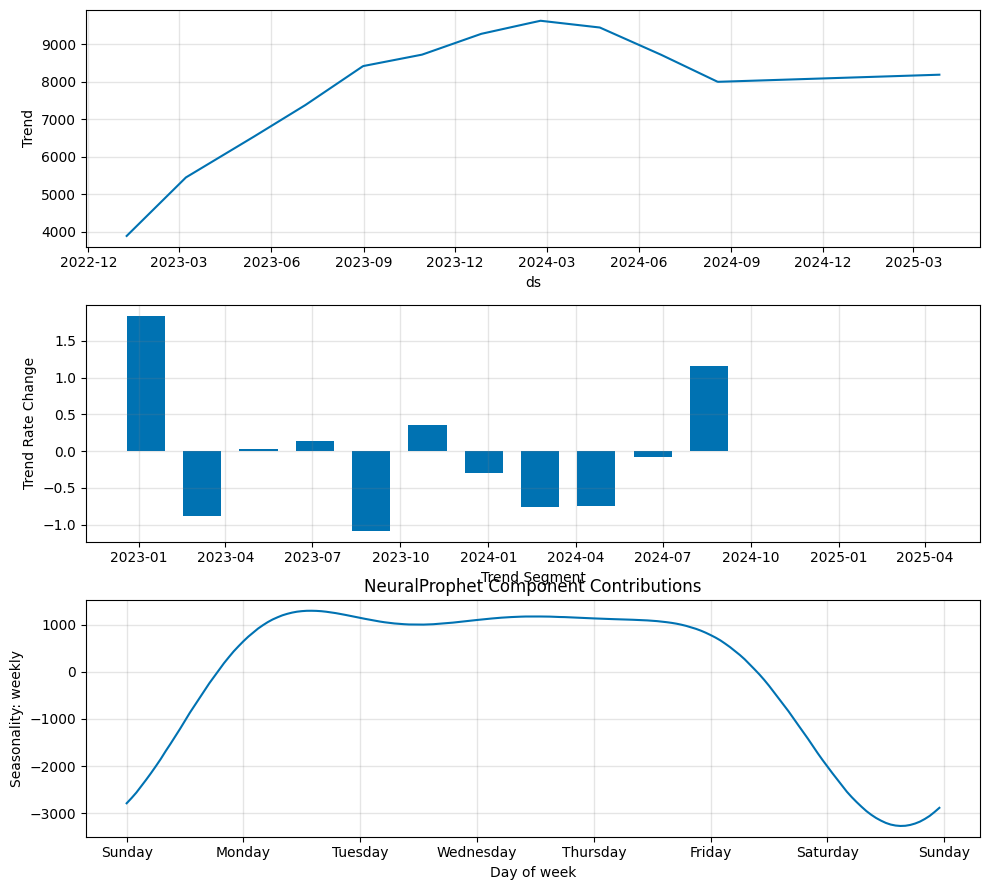


Displaying component plot for Prophet (from Hybrid)...


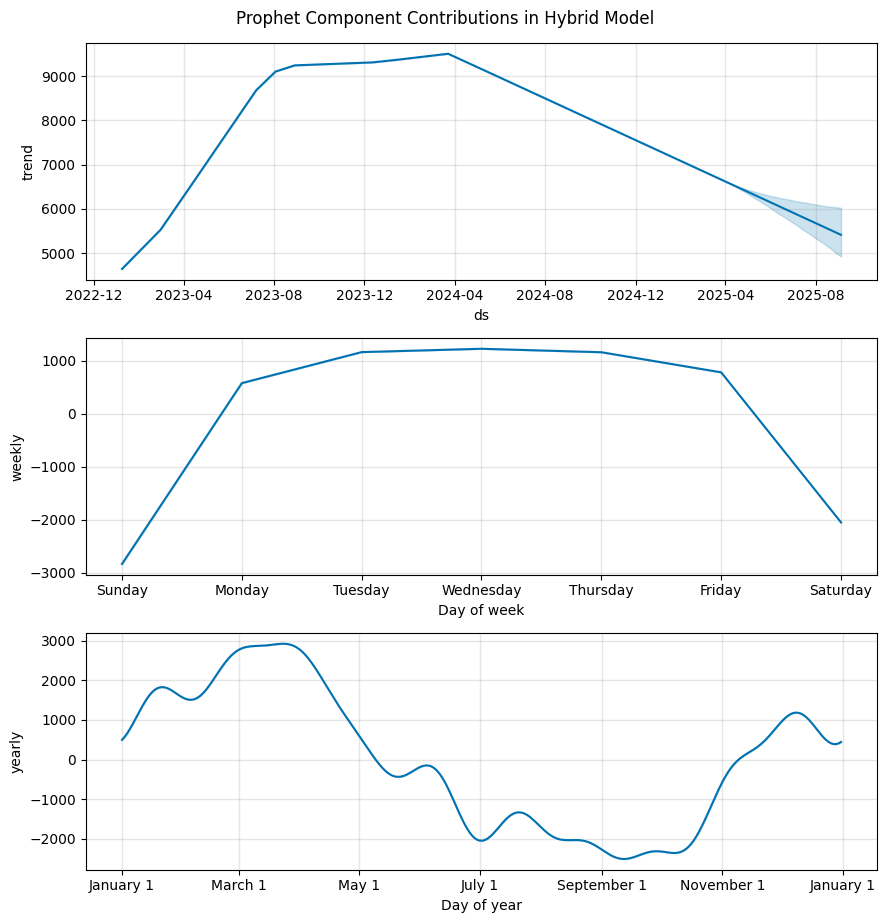


Displaying SHAP plot for XGBoost (from Hybrid)...


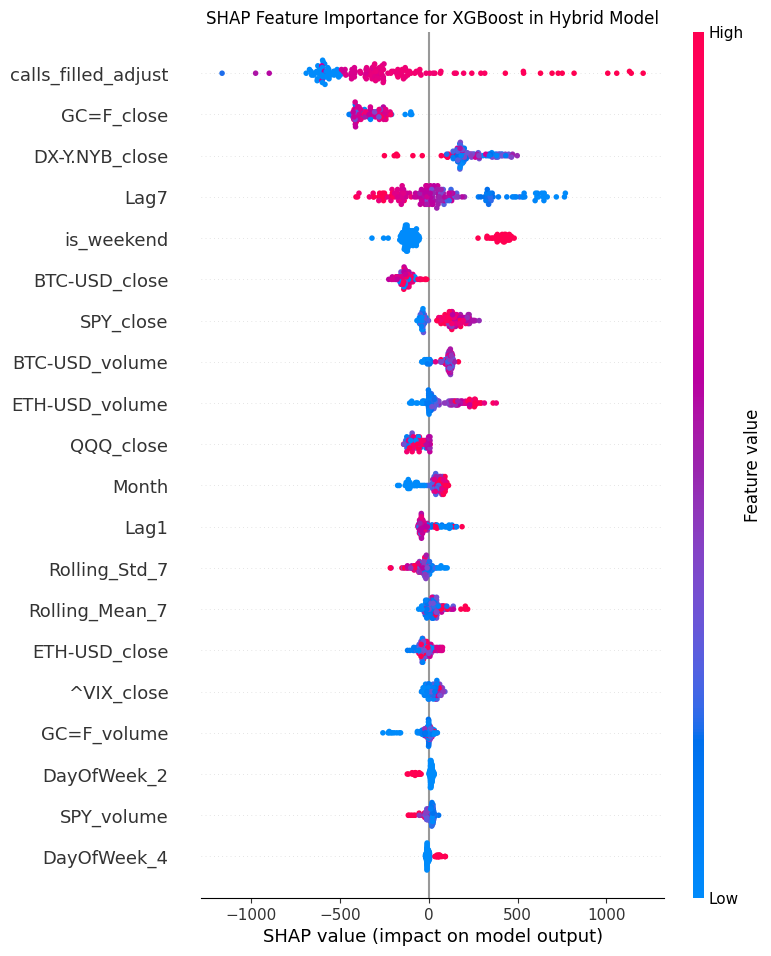

In [2]:
import shap
import matplotlib.pyplot as plt
import warnings

# Suppress a common SHAP warning
warnings.filterwarnings('ignore', category=UserWarning, module='shap.explainers._deep.deep_tf')

print("--- Preparing data and models for interpretation ---")

# 1. Create a final, persistent train/test split from the last CV fold
all_splits = list(tscv.split(df))
train_idx, test_idx = all_splits[-1]

# Original unscaled data split
train_df_final = df.iloc[train_idx]
test_df_final = df.iloc[test_idx]

# Scaled data split for LSTM
train_scaled_final = df_scaled.iloc[train_idx]
test_scaled_final = df_scaled.iloc[test_idx]

# Prepare data for models that need 'ds', 'y' format
# <<< CORRECTION HERE: Changed 'date' to 'Date' to match the actual column name
train_prophet_format = train_df_final.reset_index().rename(columns={'Date': 'ds', 'calls': 'y'})
# <<< CORRECTION HERE: Changed 'date' to 'Date' to match the actual column name
test_prophet_format = test_df_final.reset_index().rename(columns={'Date': 'ds', 'calls': 'y'})

# --- Re-train the models one last time on the final split ---

# 2a. Train Final LSTM Model
print("\nTraining final LSTM model...")
X_train_seq, y_train_seq = create_sequences(train_scaled_final)
X_test_seq, y_test_seq = create_sequences(test_scaled_final)

final_lstm_model = Sequential()
final_lstm_model.add(Input(shape=(7, len(train_scaled_final.columns))))
final_lstm_model.add(LSTM(50, activation='relu'))
final_lstm_model.add(Dense(1))
final_lstm_model.compile(optimizer='adam', loss='mse')
final_lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=0)
print("LSTM training complete.")

# 2b. Train Final Neural Prophet Model
print("\nTraining final Neural Prophet model...")
final_np_model = NeuralProphet(epochs=50, batch_size=32, learning_rate=0.01, yearly_seasonality=False, daily_seasonality=False)
final_np_model.set_plotting_backend('matplotlib')
final_np_model.fit(train_prophet_format[['ds', 'y']], freq='D')
print("Neural Prophet training complete.")

# 2c. Train Final Prophet + XGBoost Hybrid Model
print("\nTraining final Prophet + XGBoost Hybrid model...")
# Prophet part
final_prophet_model = Prophet(weekly_seasonality=True)
final_prophet_model.fit(train_prophet_format[['ds', 'y']])

# Create Prophet forecast to calculate residuals for XGBoost
train_forecast_prophet = final_prophet_model.predict(train_prophet_format[['ds']])
train_residuals = train_prophet_format['y'] - train_forecast_prophet['yhat']

# Create the forecast object needed for plotting components
future_df = final_prophet_model.make_future_dataframe(periods=len(test_prophet_format))
final_forecast_object = final_prophet_model.predict(future_df)

# XGBoost part
X_train_xgb = train_df_final[features]
X_test_xgb = test_df_final[features]

final_xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
final_xgb_model.fit(X_train_xgb, train_residuals)
print("Hybrid model training complete.")

# --- Run Interpretability Analysis ---
print("\n--- Generating Model Interpretation Plots ---")

# 1. LSTM Interpretability with SHAP
try:
    background_data = X_train_seq[:100]
    explainer_lstm = shap.DeepExplainer(final_lstm_model, background_data)
    shap_values_lstm = explainer_lstm.shap_values(X_test_seq)

    # Average SHAP values over timesteps for a summary plot
    shap_values_lstm_avg = np.mean(shap_values_lstm[0], axis=1)
    X_test_for_plot = np.mean(X_test_seq, axis=1)

    print("\nDisplaying SHAP plot for LSTM...")
    shap.summary_plot(shap_values_lstm_avg, pd.DataFrame(X_test_for_plot, columns=df_scaled.columns), show=False)
    plt.title("SHAP Feature Importance for LSTM (Averaged over Timesteps)")
    plt.show()
except Exception as e:
    print(f"An error occurred during LSTM SHAP analysis: {e}")

# 2. NeuralProphet Interpretability
try:
    print("\nDisplaying plot for Neural Prophet...")
    fig_params = final_np_model.plot_parameters()
    plt.title("NeuralProphet Component Contributions")
    plt.show()
except Exception as e:
    print(f"An error occurred during NeuralProphet plot generation: {e}")

# 3. Prophet + XGBoost Hybrid Interpretability
# 3a. Prophet Components
try:
    print("\nDisplaying component plot for Prophet (from Hybrid)...")
    fig_components = final_prophet_model.plot_components(final_forecast_object)
    plt.suptitle("Prophet Component Contributions in Hybrid Model", y=1.02)
    plt.show()
except Exception as e:
    print(f"An error occurred during Prophet components plot generation: {e}")

# 3b. XGBoost with SHAP
try:
    print("\nDisplaying SHAP plot for XGBoost (from Hybrid)...")
    explainer_xgb = shap.TreeExplainer(final_xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(X_test_xgb)

    shap.summary_plot(shap_values_xgb, X_test_xgb, show=False)
    plt.title("SHAP Feature Importance for XGBoost in Hybrid Model")
    plt.show()
except Exception as e:
    print(f"An error occurred during XGBoost SHAP analysis: {e}")